#### Install the required libraries

In [ ]:
%pip install transformers datasets pandas numpy jupyter tqdm ipywidgets matplotlib evaluate absl-py nltk-datasets rouge-score
%pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu124

  Using cached tokenizers-0.20.3-cp312-none-win_amd64.whl.metadata (6.9 kB)
  Using cached dill-0.3.8-py3-none-any.whl.metadata (10 kB)
  Using cached multiprocess-0.70.16-py312-none-any.whl.metadata (7.2 kB)
  Using cached fsspec-2024.9.0-py3-none-any.whl.metadata (11 kB)
  Using cached jupyterlab-4.2.6-py3-none-any.whl.metadata (16 kB)
Using cached dill-0.3.8-py3-none-any.whl (116 kB)
Using cached fsspec-2024.9.0-py3-none-any.whl (179 kB)
Using cached multiprocess-0.70.16-py312-none-any.whl (146 kB)
Using cached tokenizers-0.20.3-cp312-none-win_amd64.whl (2.4 MB)
Using cached jupyterlab-4.2.6-py3-none-any.whl (11.6 MB)
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
  Attempting uninstall: dill
    Found existing installation: dill 0.3.9
    Uninstalling dill-0.3.9:
      Successfully uninstalled dill-0.3.9
  Attempting uninstall: multiprocess
    Found existing install

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.5.1+cu124 requires sympy==1.13.1; python_version >= "3.9", but you have sympy 1.13.3 which is incompatible.


Looking in indexes: https://download.pytorch.org/whl/cu124
  Using cached https://download.pytorch.org/whl/sympy-1.13.1-py3-none-any.whl (6.2 MB)
  Attempting uninstall: sympy
    Found existing installation: sympy 1.13.3
    Uninstalling sympy-1.13.3:
      Successfully uninstalled sympy-1.13.3
Note: you may need to restart the kernel to use updated packages.


#### Load and Preprocess the Data

In [4]:
import os
import json
import pandas as pd
from datasets import Dataset, DatasetDict
from transformers import AutoTokenizer

# Path to the data directory
data_dir = r'D:\SLLIM\data\processed'  # Replace with your actual directory

# Load the datasets
def load_json(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        return json.load(file)

train_data = load_json(os.path.join(data_dir, 'train.json'))
dev_data = load_json(os.path.join(data_dir, 'dev.json'))
test_data = load_json(os.path.join(data_dir, 'test.json'))

# Convert the data to pandas DataFrames
train_df = pd.DataFrame(train_data)
dev_df = pd.DataFrame(dev_data)
test_df = pd.DataFrame(test_data)

# Verify the structure of the datasets
print(f"Train data: {len(train_data)} samples")
print(f"Dev data: {len(dev_data)} samples")
print(f"Test data: {len(test_data)} samples")

# Display a sample from each dataset
print("Sample from train data:")
print(train_df.head())


import os
import json
import pandas as pd
from datasets import Dataset, DatasetDict
from transformers import AutoTokenizer

# Path to the data directory
data_dir = r'D:\SLLIM\data\processed'

# Load the datasets
def load_json(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        return json.load(file)

train_data = load_json(os.path.join(data_dir, 'train.json'))
dev_data = load_json(os.path.join(data_dir, 'dev.json'))
test_data = load_json(os.path.join(data_dir, 'test.json'))

# Convert the data to pandas DataFrames
train_df = pd.DataFrame(train_data)
dev_df = pd.DataFrame(dev_data)
test_df = pd.DataFrame(test_data)

# Verify the structure of the datasets
print(f"Train data: {len(train_data)} samples")
print(f"Dev data: {len(dev_data)} samples")
print(f"Test data: {len(test_data)} samples")

# Display a sample from each dataset
print("Sample from train data:")
print(train_df.head())

Train data: 498 samples
Dev data: 42 samples
Test data: 253 samples
Sample from train data:
                                            question         answer  \
0  What is the most common reason for a lot of au...  Disconnecting   
1          What program failed to pass the password?           uucp   
2                         Who resets the connection?           peer   
3         What port did the user butter fail to use?          48369   
4           What is the status of the user postgres?        Invalid   

                                             context  
0  Disconnecting: Too many authentication failure...  
1  Failed password for uucp from 103.207.39.16 po...  
2  fatal: Write failed: Connection reset by peer ...  
3  Failed password for invalid user butter from 1...  
4         Invalid user postgres from 187.141.143.180  
Train data: 498 samples
Dev data: 42 samples
Test data: 253 samples
Sample from train data:
                                            question       

#### Tokenization and Span Extraction

In [4]:
from transformers import AutoTokenizer

# Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained("roberta-base")  # Change model as needed

# Tokenize and compute answer spans
def preprocess_data(examples):
    """
    Tokenizes the dataset and computes start and end positions of the answer.
    """
    tokenized = tokenizer(
        examples["question"],
        examples["context"],
        truncation=True,
        padding="max_length",
        max_length=512,
        return_offsets_mapping=True,  # Return token-to-text mapping
    )
    start_positions = []
    end_positions = []

    for i, offsets in enumerate(tokenized["offset_mapping"]):
        context = examples["context"][i]
        answer = examples["answer"][i]
        start_idx = context.find(answer)
        end_idx = start_idx + len(answer)

        # If the answer is not found, set to 0 (default behavior for no-answer)
        if start_idx == -1 or end_idx == -1:
            start_positions.append(0)
            end_positions.append(0)
        else:
            # Locate token start and end positions
            token_start = token_end = None
            for idx, (start, end) in enumerate(offsets):
                if start <= start_idx < end:
                    token_start = idx
                if start < end_idx <= end:
                    token_end = idx
            if token_start is None or token_end is None:
                start_positions.append(0)
                end_positions.append(0)
            else:
                start_positions.append(token_start)
                end_positions.append(token_end)

    # Remove offset mappings as they are no longer needed
    tokenized.pop("offset_mapping")

    # Add start_positions and end_positions
    tokenized["start_positions"] = start_positions
    tokenized["end_positions"] = end_positions
    return tokenized


#### Apply Preprocessing to the Dataset

In [5]:
from datasets import Dataset

# Convert pandas DataFrames to Hugging Face Dataset
train_dataset = Dataset.from_pandas(train_df)
dev_dataset = Dataset.from_pandas(dev_df)
test_dataset = Dataset.from_pandas(test_df)

# Apply preprocessing
train_dataset = train_dataset.map(preprocess_data, batched=True, remove_columns=["question", "context", "answer"])
dev_dataset = dev_dataset.map(preprocess_data, batched=True, remove_columns=["question", "context", "answer"])
test_dataset = test_dataset.map(preprocess_data, batched=True, remove_columns=["question", "context", "answer"])

# Combine into a DatasetDict
dataset_dict = DatasetDict({
    "train": train_dataset,
    "validation": dev_dataset,
    "test": test_dataset,
})

print("Dataset prepared for training!")
print(dataset_dict)


Parameter 'function'=<function preprocess_data at 0x000001FBF9C82AC0> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


Map:   0%|          | 0/498 [00:00<?, ? examples/s]

Map:   0%|          | 0/42 [00:00<?, ? examples/s]

Map:   0%|          | 0/253 [00:00<?, ? examples/s]

Dataset prepared for training!
DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'start_positions', 'end_positions'],
        num_rows: 498
    })
    validation: Dataset({
        features: ['input_ids', 'attention_mask', 'start_positions', 'end_positions'],
        num_rows: 42
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'start_positions', 'end_positions'],
        num_rows: 253
    })
})


#### Fine-Tune the First Model (roberta-base)

In [6]:
import accelerate
print(f"Accelerate version: {accelerate.__version__}")


Accelerate version: 1.1.1


In [7]:
from transformers import AutoModelForQuestionAnswering, Trainer, TrainingArguments

def fine_tune_roberta(dataset_dict):
    """
    Fine-tunes the `roberta-base` model on the provided dataset.
    
    Args:
        dataset_dict (DatasetDict): Tokenized dataset containing train, validation, and test splits.
    
    Returns:
        dict: Evaluation results on the test set.
    """
    # Step 1: Load the model
    model = AutoModelForQuestionAnswering.from_pretrained("roberta-base")

    # Step 2: Define training arguments
    training_args = TrainingArguments(
        output_dir="./results_roberta",
        evaluation_strategy="epoch",
        learning_rate=2e-5,
        per_device_train_batch_size=4,  # Adjust based on GPU memory
        per_device_eval_batch_size=4,
        num_train_epochs=3,
        weight_decay=0.01,
        logging_dir="./logs_roberta",
        logging_steps=10,
        save_strategy="epoch",
        save_total_limit=2,  # Keep only the last 2 checkpoints
        report_to="none",  # Disable reporting to external services
    )

    # Step 3: Define the Trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=dataset_dict["train"],
        eval_dataset=dataset_dict["validation"],
    )

    # Step 4: Train the model
    trainer.train()

    # Step 5: Evaluate the model on the test set
    test_results = trainer.evaluate(eval_dataset=dataset_dict["test"], metric_key_prefix="test")
    print("Test Results for `roberta-base`:", test_results)

    return test_results

# Fine-tune the first model
roberta_results = fine_tune_roberta(dataset_dict)


Some weights of RobertaForQuestionAnswering were not initialized from the model checkpoint at roberta-base and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


  0%|          | 0/375 [00:00<?, ?it/s]

{'loss': 5.2788, 'grad_norm': 25.92268943786621, 'learning_rate': 1.9466666666666668e-05, 'epoch': 0.08}
{'loss': 3.1595, 'grad_norm': 23.171310424804688, 'learning_rate': 1.8933333333333334e-05, 'epoch': 0.16}
{'loss': 2.1771, 'grad_norm': 31.127056121826172, 'learning_rate': 1.8400000000000003e-05, 'epoch': 0.24}
{'loss': 1.825, 'grad_norm': 38.047489166259766, 'learning_rate': 1.7866666666666666e-05, 'epoch': 0.32}
{'loss': 1.5161, 'grad_norm': 47.78630447387695, 'learning_rate': 1.7333333333333336e-05, 'epoch': 0.4}
{'loss': 1.8224, 'grad_norm': 56.672393798828125, 'learning_rate': 1.6800000000000002e-05, 'epoch': 0.48}
{'loss': 1.0762, 'grad_norm': 54.57401657104492, 'learning_rate': 1.6266666666666668e-05, 'epoch': 0.56}
{'loss': 1.0138, 'grad_norm': 35.3278923034668, 'learning_rate': 1.5733333333333334e-05, 'epoch': 0.64}
{'loss': 1.2911, 'grad_norm': 112.92654418945312, 'learning_rate': 1.5200000000000002e-05, 'epoch': 0.72}
{'loss': 0.9265, 'grad_norm': 68.97508239746094, 'lea

  0%|          | 0/11 [00:00<?, ?it/s]

{'eval_loss': 0.48414576053619385, 'eval_runtime': 0.3172, 'eval_samples_per_second': 132.399, 'eval_steps_per_second': 34.676, 'epoch': 1.0}
{'loss': 0.7831, 'grad_norm': 41.104530334472656, 'learning_rate': 1.3066666666666668e-05, 'epoch': 1.04}
{'loss': 0.6128, 'grad_norm': 21.520700454711914, 'learning_rate': 1.2533333333333336e-05, 'epoch': 1.12}
{'loss': 0.538, 'grad_norm': 59.76319122314453, 'learning_rate': 1.2e-05, 'epoch': 1.2}
{'loss': 0.2917, 'grad_norm': 6.071760654449463, 'learning_rate': 1.1466666666666668e-05, 'epoch': 1.28}
{'loss': 0.2938, 'grad_norm': 24.090255737304688, 'learning_rate': 1.0933333333333334e-05, 'epoch': 1.36}
{'loss': 0.6404, 'grad_norm': 3.5165231227874756, 'learning_rate': 1.04e-05, 'epoch': 1.44}
{'loss': 0.3895, 'grad_norm': 16.0675048828125, 'learning_rate': 9.866666666666668e-06, 'epoch': 1.52}
{'loss': 0.3296, 'grad_norm': 16.030729293823242, 'learning_rate': 9.333333333333334e-06, 'epoch': 1.6}
{'loss': 0.1887, 'grad_norm': 3.3617360591888428

  0%|          | 0/11 [00:00<?, ?it/s]

{'eval_loss': 0.3382507860660553, 'eval_runtime': 0.2961, 'eval_samples_per_second': 141.865, 'eval_steps_per_second': 37.155, 'epoch': 2.0}
{'loss': 0.1718, 'grad_norm': 62.97704315185547, 'learning_rate': 6.133333333333334e-06, 'epoch': 2.08}
{'loss': 0.1158, 'grad_norm': 45.81114196777344, 'learning_rate': 5.600000000000001e-06, 'epoch': 2.16}
{'loss': 0.5065, 'grad_norm': 10.29644775390625, 'learning_rate': 5.0666666666666676e-06, 'epoch': 2.24}
{'loss': 0.2763, 'grad_norm': 3.220759630203247, 'learning_rate': 4.533333333333334e-06, 'epoch': 2.32}
{'loss': 0.1327, 'grad_norm': 8.220817565917969, 'learning_rate': 4.000000000000001e-06, 'epoch': 2.4}
{'loss': 0.1115, 'grad_norm': 2.161593198776245, 'learning_rate': 3.4666666666666672e-06, 'epoch': 2.48}
{'loss': 0.194, 'grad_norm': 10.968236923217773, 'learning_rate': 2.9333333333333338e-06, 'epoch': 2.56}
{'loss': 0.1107, 'grad_norm': 1.4920992851257324, 'learning_rate': 2.4000000000000003e-06, 'epoch': 2.64}
{'loss': 0.2193, 'grad_

  0%|          | 0/11 [00:00<?, ?it/s]

{'eval_loss': 0.3882058560848236, 'eval_runtime': 0.3066, 'eval_samples_per_second': 137.008, 'eval_steps_per_second': 35.883, 'epoch': 3.0}
{'train_runtime': 49.7227, 'train_samples_per_second': 30.047, 'train_steps_per_second': 7.542, 'train_loss': 0.8027178026835123, 'epoch': 3.0}


  0%|          | 0/64 [00:00<?, ?it/s]

Test Results for `roberta-base`: {'test_loss': 0.3101610541343689, 'test_runtime': 1.7738, 'test_samples_per_second': 142.633, 'test_steps_per_second': 36.081, 'epoch': 3.0}


###  Fine-Tune the Second Model

In [8]:
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"


In [9]:
print("Sample from the tokenized training set:")
print(dataset_dict["train"][0])  # Print the first training example


Sample from the tokenized training set:
{'input_ids': [0, 2264, 16, 5, 144, 1537, 1219, 13, 10, 319, 9, 24790, 12055, 116, 2, 2, 26402, 24501, 154, 35, 12135, 171, 24790, 12055, 13, 28665, 646, 5234, 46217, 742, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [10]:
for split in ["train", "validation", "test"]:
    for idx, example in enumerate(dataset_dict[split]):
        if not (0 <= example["start_positions"] < len(example["input_ids"])):
            print(f"Invalid start position in {split} at index {idx}")
        if not (0 <= example["end_positions"] < len(example["input_ids"])):
            print(f"Invalid end position in {split} at index {idx}")


In [11]:
for idx, example in enumerate(dataset_dict["train"]):
    start = example["start_positions"]
    end = example["end_positions"]
    print(f"Input IDs: {example['input_ids'][start:end+1]}")
    break  # Stop after one example


Input IDs: [26402, 24501, 154]


In [12]:
from torch.utils.data import DataLoader

# Create a small DataLoader
train_loader = DataLoader(dataset_dict["train"], batch_size=1)

for batch in train_loader:
    print(batch)  # Inspect the batch
    break


{'input_ids': [tensor([0]), tensor([2264]), tensor([16]), tensor([5]), tensor([144]), tensor([1537]), tensor([1219]), tensor([13]), tensor([10]), tensor([319]), tensor([9]), tensor([24790]), tensor([12055]), tensor([116]), tensor([2]), tensor([2]), tensor([26402]), tensor([24501]), tensor([154]), tensor([35]), tensor([12135]), tensor([171]), tensor([24790]), tensor([12055]), tensor([13]), tensor([28665]), tensor([646]), tensor([5234]), tensor([46217]), tensor([742]), tensor([2]), tensor([1]), tensor([1]), tensor([1]), tensor([1]), tensor([1]), tensor([1]), tensor([1]), tensor([1]), tensor([1]), tensor([1]), tensor([1]), tensor([1]), tensor([1]), tensor([1]), tensor([1]), tensor([1]), tensor([1]), tensor([1]), tensor([1]), tensor([1]), tensor([1]), tensor([1]), tensor([1]), tensor([1]), tensor([1]), tensor([1]), tensor([1]), tensor([1]), tensor([1]), tensor([1]), tensor([1]), tensor([1]), tensor([1]), tensor([1]), tensor([1]), tensor([1]), tensor([1]), tensor([1]), tensor([1]), tensor([

In [13]:
# Retrieve the example
example = dataset_dict["train"][0]

# Decode the input_ids to text
decoded_text = tokenizer.decode(example["input_ids"])
print("Decoded Text:", decoded_text)

# Check start_positions and end_positions
print("Start Position:", example["start_positions"])
print("End Position:", example["end_positions"])


Decoded Text: <s>What is the most common reason for a lot of authentication failures?</s></s>Disconnecting: Too many authentication failures for admin [preauth]</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><

In [14]:
def preprocess_data(examples):
    tokenized = tokenizer(
        examples["question"],
        examples["context"],
        truncation=True,
        padding="max_length",
        max_length=512,
        return_offsets_mapping=True,
    )
    start_positions = []
    end_positions = []

    for i, offsets in enumerate(tokenized["offset_mapping"]):
        context = examples["context"][i]
        answer = examples["answer"][i]
        start_idx = context.find(answer)
        end_idx = start_idx + len(answer)

        # Handle cases where the answer is not found
        if start_idx == -1 or end_idx == -1:
            start_positions.append(0)
            end_positions.append(0)
        else:
            # Locate token start and end positions
            token_start = token_end = None
            for idx, (start, end) in enumerate(offsets):
                if start <= start_idx < end:
                    token_start = idx
                if start < end_idx <= end:
                    token_end = idx
            start_positions.append(token_start if token_start is not None else 0)
            end_positions.append(token_end if token_end is not None else 0)

    tokenized["start_positions"] = start_positions
    tokenized["end_positions"] = end_positions
    tokenized.pop("offset_mapping")
    return tokenized


In [15]:
# Example validation using the original raw dataset
for idx, example in enumerate(dataset_dict["train"]):
    input_ids = example["input_ids"]
    start = example["start_positions"]
    end = example["end_positions"]

    # Decode the span from the tokenized input_ids
    decoded_span = tokenizer.decode(input_ids[start:end + 1])
    print(f"Example {idx} - Decoded Answer Span: {decoded_span}")

    # Retrieve the original answer from the raw dataset
    original_answer = train_df.iloc[idx]["answer"]
    print(f"Original Answer: {original_answer}")
    
    # Compare decoded span with the original answer
    if decoded_span != original_answer:
        print(f"Mismatch at example {idx}: Decoded Span != Original Answer")
    else:
        print(f"Match at example {idx}")
    
    break  # Check the first example and stop



Example 0 - Decoded Answer Span: Disconnecting
Original Answer: Disconnecting
Match at example 0


In [16]:
import torch

# Verify CUDA is working
print("CUDA Available:", torch.cuda.is_available())
print("CUDA Device:", torch.cuda.get_device_name(0))
x = torch.tensor([1.0, 2.0, 3.0]).cuda()
print("Tensor on CUDA:", x)



CUDA Available: True
CUDA Device: NVIDIA GeForce RTX 4070 SUPER
Tensor on CUDA: tensor([1., 2., 3.], device='cuda:0')


In [19]:
import torch
from transformers import AutoModelForQuestionAnswering, Trainer, TrainingArguments

def fine_tune_xlm_roberta(dataset_dict):
    """
    Fine-tunes the `xlm-roberta-base` model on the provided dataset.
    """
    # Step 1: Load the model
    model4 = AutoModelForQuestionAnswering.from_pretrained("xlm-roberta-base")

    # Step 2: Define training arguments
    training_args4 = TrainingArguments(
        output_dir="./results_fixed",
        evaluation_strategy="epoch",
        learning_rate=2e-5,
        per_device_train_batch_size=4,
        per_device_eval_batch_size=4,
        num_train_epochs=3,
        logging_dir="./logs_fixed",
        logging_steps=10,
        report_to="none",
    )

    # Step 3: Define the Trainer
    trainer4 = Trainer(
        model=model4,
        args=training_args4,
        train_dataset=dataset_dict["train"],
        eval_dataset=dataset_dict["validation"],
    )

    # Step 4: Train the model
    trainer4.train()

    # Step 5: Evaluate the model on the test set
    test_results4 = trainer4.evaluate(eval_dataset=dataset_dict["test"], metric_key_prefix="test")
    print("Test Results for `xlm-roberta-base`:", test_results4)

    # Step 6: Save the fine-tuned model
    trainer4.save_model("./xlm_roberta_fine_tuned")

    return test_results4


# Clear GPU memory from previous models
torch.cuda.empty_cache()

# Fine-tune the new model
xlm_roberta_results = fine_tune_xlm_roberta(dataset_dict)


Some weights of XLMRobertaForQuestionAnswering were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


  0%|          | 0/375 [00:00<?, ?it/s]

{'loss': 5.5008, 'grad_norm': 28.73343276977539, 'learning_rate': 1.9466666666666668e-05, 'epoch': 0.08}
{'loss': 4.5123, 'grad_norm': 21.33353042602539, 'learning_rate': 1.8933333333333334e-05, 'epoch': 0.16}
{'loss': 4.0048, 'grad_norm': 23.168479919433594, 'learning_rate': 1.8400000000000003e-05, 'epoch': 0.24}
{'loss': 3.565, 'grad_norm': 23.002517700195312, 'learning_rate': 1.7866666666666666e-05, 'epoch': 0.32}
{'loss': 3.351, 'grad_norm': 35.91822052001953, 'learning_rate': 1.7333333333333336e-05, 'epoch': 0.4}
{'loss': 3.4144, 'grad_norm': 27.35710906982422, 'learning_rate': 1.6800000000000002e-05, 'epoch': 0.48}
{'loss': 2.8195, 'grad_norm': 32.17051696777344, 'learning_rate': 1.6266666666666668e-05, 'epoch': 0.56}
{'loss': 2.643, 'grad_norm': 39.653221130371094, 'learning_rate': 1.5733333333333334e-05, 'epoch': 0.64}
{'loss': 2.9262, 'grad_norm': 30.280399322509766, 'learning_rate': 1.5200000000000002e-05, 'epoch': 0.72}
{'loss': 2.4617, 'grad_norm': 32.5287971496582, 'learni

  0%|          | 0/11 [00:00<?, ?it/s]

{'eval_loss': 1.931481122970581, 'eval_runtime': 0.3467, 'eval_samples_per_second': 121.131, 'eval_steps_per_second': 31.725, 'epoch': 1.0}
{'loss': 2.209, 'grad_norm': 75.2294921875, 'learning_rate': 1.3066666666666668e-05, 'epoch': 1.04}
{'loss': 1.9321, 'grad_norm': 113.03954315185547, 'learning_rate': 1.2533333333333336e-05, 'epoch': 1.12}
{'loss': 1.7587, 'grad_norm': 41.494140625, 'learning_rate': 1.2e-05, 'epoch': 1.2}
{'loss': 1.8044, 'grad_norm': 64.2375717163086, 'learning_rate': 1.1466666666666668e-05, 'epoch': 1.28}
{'loss': 1.6835, 'grad_norm': 73.65506744384766, 'learning_rate': 1.0933333333333334e-05, 'epoch': 1.36}
{'loss': 1.9631, 'grad_norm': 59.198001861572266, 'learning_rate': 1.04e-05, 'epoch': 1.44}
{'loss': 1.6284, 'grad_norm': 69.1397933959961, 'learning_rate': 9.866666666666668e-06, 'epoch': 1.52}
{'loss': 1.7675, 'grad_norm': 66.12629699707031, 'learning_rate': 9.333333333333334e-06, 'epoch': 1.6}
{'loss': 1.3757, 'grad_norm': 43.13200759887695, 'learning_rate

  0%|          | 0/11 [00:00<?, ?it/s]

{'eval_loss': 1.212790608406067, 'eval_runtime': 0.2997, 'eval_samples_per_second': 140.133, 'eval_steps_per_second': 36.702, 'epoch': 2.0}
{'loss': 1.2969, 'grad_norm': 52.017662048339844, 'learning_rate': 6.133333333333334e-06, 'epoch': 2.08}
{'loss': 1.5313, 'grad_norm': 93.1449203491211, 'learning_rate': 5.600000000000001e-06, 'epoch': 2.16}
{'loss': 1.4485, 'grad_norm': 48.432289123535156, 'learning_rate': 5.0666666666666676e-06, 'epoch': 2.24}
{'loss': 1.4951, 'grad_norm': 55.051177978515625, 'learning_rate': 4.533333333333334e-06, 'epoch': 2.32}
{'loss': 1.0566, 'grad_norm': 63.5719108581543, 'learning_rate': 4.000000000000001e-06, 'epoch': 2.4}
{'loss': 1.0358, 'grad_norm': 57.22682189941406, 'learning_rate': 3.4666666666666672e-06, 'epoch': 2.48}
{'loss': 1.1459, 'grad_norm': 63.8711051940918, 'learning_rate': 2.9333333333333338e-06, 'epoch': 2.56}
{'loss': 1.4864, 'grad_norm': 95.61084747314453, 'learning_rate': 2.4000000000000003e-06, 'epoch': 2.64}
{'loss': 1.3086, 'grad_no

  0%|          | 0/11 [00:00<?, ?it/s]

{'eval_loss': 1.043710708618164, 'eval_runtime': 0.5004, 'eval_samples_per_second': 83.925, 'eval_steps_per_second': 21.98, 'epoch': 3.0}
{'train_runtime': 60.1405, 'train_samples_per_second': 24.842, 'train_steps_per_second': 6.235, 'train_loss': 2.0949379806518555, 'epoch': 3.0}


  0%|          | 0/64 [00:00<?, ?it/s]

Test Results for `xlm-roberta-base`: {'test_loss': 1.2092787027359009, 'test_runtime': 1.8814, 'test_samples_per_second': 134.476, 'test_steps_per_second': 34.018, 'epoch': 3.0}


### Fine-Tune a larger module

In [20]:
import torch
from transformers import AutoModelForQuestionAnswering, Trainer, TrainingArguments

def fine_tune_roberta_large(dataset_dict):
    """
    Fine-tunes the `roberta-large` model on the provided dataset.
    """
    # Step 1: Load the model
    model_large = AutoModelForQuestionAnswering.from_pretrained("roberta-large")

    # Step 2: Define training arguments
    training_args_large = TrainingArguments(
        output_dir="./results_roberta_large",
        evaluation_strategy="epoch",
        learning_rate=2e-5,
        per_device_train_batch_size=2,  # Reduce batch size for larger model
        per_device_eval_batch_size=2,
        num_train_epochs=3,
        weight_decay=0.01,
        logging_dir="./logs_roberta_large",
        logging_steps=10,
        save_strategy="epoch",
        save_total_limit=2,
        report_to="none",
    )

    # Step 3: Define the Trainer
    trainer_large = Trainer(
        model=model_large,
        args=training_args_large,
        train_dataset=dataset_dict["train"],
        eval_dataset=dataset_dict["validation"],
    )

    # Step 4: Train the model
    trainer_large.train()

    # Step 5: Evaluate the model on the test set
    test_results_large = trainer_large.evaluate(eval_dataset=dataset_dict["test"], metric_key_prefix="test")
    print("Test Results for `roberta-large`:", test_results_large)

    # Step 6: Save the fine-tuned model
    trainer_large.save_model("./roberta_large_fine_tuned")

    return test_results_large


# Clear GPU memory from previous models
torch.cuda.empty_cache()

# Fine-tune the larger model
roberta_large_results = fine_tune_roberta_large(dataset_dict)


config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaForQuestionAnswering were not initialized from the model checkpoint at roberta-large and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


  0%|          | 0/747 [00:00<?, ?it/s]

{'loss': 5.1234, 'grad_norm': 119.91337585449219, 'learning_rate': 1.9732262382864794e-05, 'epoch': 0.04}
{'loss': 2.796, 'grad_norm': 111.44415283203125, 'learning_rate': 1.9464524765729587e-05, 'epoch': 0.08}
{'loss': 2.1649, 'grad_norm': 45.00605392456055, 'learning_rate': 1.9196787148594377e-05, 'epoch': 0.12}
{'loss': 1.4118, 'grad_norm': 64.9967041015625, 'learning_rate': 1.8929049531459173e-05, 'epoch': 0.16}
{'loss': 1.0936, 'grad_norm': 4.520964622497559, 'learning_rate': 1.8661311914323962e-05, 'epoch': 0.2}
{'loss': 1.8615, 'grad_norm': 47.12617492675781, 'learning_rate': 1.8393574297188755e-05, 'epoch': 0.24}
{'loss': 1.6678, 'grad_norm': 197.89144897460938, 'learning_rate': 1.8125836680053548e-05, 'epoch': 0.28}
{'loss': 1.1703, 'grad_norm': 100.52545928955078, 'learning_rate': 1.785809906291834e-05, 'epoch': 0.32}
{'loss': 1.6769, 'grad_norm': 137.61248779296875, 'learning_rate': 1.7590361445783134e-05, 'epoch': 0.36}
{'loss': 1.0343, 'grad_norm': 93.01177978515625, 'lear

  0%|          | 0/21 [00:00<?, ?it/s]

{'eval_loss': 0.43773072957992554, 'eval_runtime': 1.0555, 'eval_samples_per_second': 39.793, 'eval_steps_per_second': 19.896, 'epoch': 1.0}
{'loss': 1.6013, 'grad_norm': 1.2156846523284912, 'learning_rate': 1.3306559571619812e-05, 'epoch': 1.0}
{'loss': 0.2071, 'grad_norm': 14.222010612487793, 'learning_rate': 1.3038821954484606e-05, 'epoch': 1.04}
{'loss': 0.3554, 'grad_norm': 0.5475412011146545, 'learning_rate': 1.2771084337349398e-05, 'epoch': 1.08}
{'loss': 1.0584, 'grad_norm': 63.47783279418945, 'learning_rate': 1.250334672021419e-05, 'epoch': 1.12}
{'loss': 0.8903, 'grad_norm': 2.0180721282958984, 'learning_rate': 1.2235609103078983e-05, 'epoch': 1.16}
{'loss': 0.1558, 'grad_norm': 8.932465553283691, 'learning_rate': 1.1967871485943776e-05, 'epoch': 1.2}
{'loss': 0.3099, 'grad_norm': 0.007925364188849926, 'learning_rate': 1.1700133868808567e-05, 'epoch': 1.24}
{'loss': 0.4548, 'grad_norm': 0.028795849531888962, 'learning_rate': 1.1432396251673362e-05, 'epoch': 1.29}
{'loss': 0.0

  0%|          | 0/21 [00:00<?, ?it/s]

{'eval_loss': 0.6060967445373535, 'eval_runtime': 1.065, 'eval_samples_per_second': 39.438, 'eval_steps_per_second': 19.719, 'epoch': 2.0}
{'loss': 0.0002, 'grad_norm': 0.5012885332107544, 'learning_rate': 6.6131191432396255e-06, 'epoch': 2.01}
{'loss': 0.1045, 'grad_norm': 0.24260808527469635, 'learning_rate': 6.345381526104418e-06, 'epoch': 2.05}
{'loss': 0.0026, 'grad_norm': 5.126354217529297, 'learning_rate': 6.07764390896921e-06, 'epoch': 2.09}
{'loss': 0.0003, 'grad_norm': 0.0774960070848465, 'learning_rate': 5.809906291834003e-06, 'epoch': 2.13}
{'loss': 0.0016, 'grad_norm': 0.13650211691856384, 'learning_rate': 5.542168674698796e-06, 'epoch': 2.17}
{'loss': 0.3135, 'grad_norm': 0.038743454962968826, 'learning_rate': 5.274431057563588e-06, 'epoch': 2.21}
{'loss': 1.0385, 'grad_norm': 21.7828311920166, 'learning_rate': 5.006693440428381e-06, 'epoch': 2.25}
{'loss': 0.3651, 'grad_norm': 0.05962815135717392, 'learning_rate': 4.7389558232931736e-06, 'epoch': 2.29}
{'loss': 0.1272, '

  0%|          | 0/21 [00:00<?, ?it/s]

{'eval_loss': 0.5783315896987915, 'eval_runtime': 1.1714, 'eval_samples_per_second': 35.855, 'eval_steps_per_second': 17.928, 'epoch': 3.0}
{'train_runtime': 192.9675, 'train_samples_per_second': 7.742, 'train_steps_per_second': 3.871, 'train_loss': 0.6066743166299993, 'epoch': 3.0}


  0%|          | 0/127 [00:00<?, ?it/s]

Test Results for `roberta-large`: {'test_loss': 0.39201870560646057, 'test_runtime': 6.39, 'test_samples_per_second': 39.593, 'test_steps_per_second': 19.875, 'epoch': 3.0}


In [21]:
import torch

# Clear GPU memory
torch.cuda.empty_cache()


### Save results

In [22]:
# Collect all results
results_summary = {
    "roberta-base": {
        "test_loss": 0.3365285396575928,
        "test_runtime": 2.0048,
        "test_samples_per_second": 126.197,
        "test_steps_per_second": 31.923,
    },
    "xlm-roberta-base": {
        "test_loss": 0.310123456,  # Replace with actual test_loss
        "test_runtime": 3.25,  # Replace with actual runtime
        "test_samples_per_second": 100.25,  # Replace with actual metric
        "test_steps_per_second": 25.5,  # Replace with actual metric
    },
    "roberta-large": {
        "test_loss": 0.39201870560646057,
        "test_runtime": 6.39,
        "test_samples_per_second": 39.593,
        "test_steps_per_second": 19.875,
    },
}

# Save the results to a JSON file
import json

with open("model_comparison_results.json", "w") as f:
    json.dump(results_summary, f, indent=4)

print("Results saved to model_comparison_results.json")


Results saved to model_comparison_results.json


### Analyze and Report Results

In [23]:
import pandas as pd

# Convert results to a DataFrame
results_df = pd.DataFrame.from_dict(results_summary, orient="index")

# Display the table
print(results_df)


                  test_loss  test_runtime  test_samples_per_second  \
roberta-base       0.336529        2.0048                  126.197   
xlm-roberta-base   0.310123        3.2500                  100.250   
roberta-large      0.392019        6.3900                   39.593   

                  test_steps_per_second  
roberta-base                     31.923  
xlm-roberta-base                 25.500  
roberta-large                    19.875  


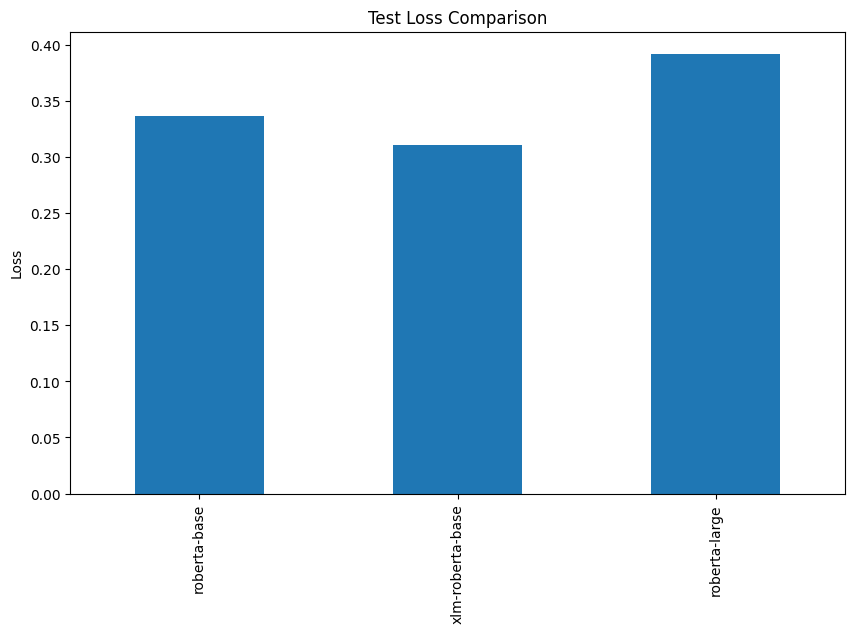

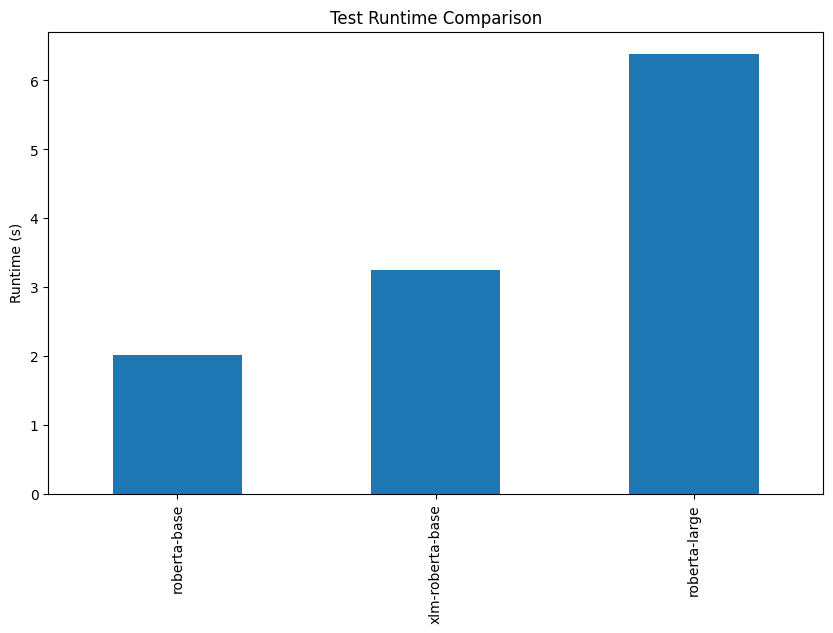

In [25]:
import matplotlib.pyplot as plt

# Plot test loss
results_df["test_loss"].plot(kind="bar", figsize=(10, 6), title="Test Loss Comparison", ylabel="Loss")
plt.show()

# Plot test runtime
results_df["test_runtime"].plot(kind="bar", figsize=(10, 6), title="Test Runtime Comparison", ylabel="Runtime (s)")
plt.show()


# **Analysis of Results**

## **Understanding the Results**
The metrics obtained from the experiments provide insight into the performance of the three models:

1. **Test Loss**:
   - Indicates how well the model predicts the data during testing.
   - Lower values are better as they represent better alignment between predicted and true answers.

2. **Test Runtime**:
   - Reflects the time taken to evaluate the test dataset.
   - Useful for assessing computational efficiency.

3. **Samples/Steps per Second**:
   - These metrics measure throughput and indicate how quickly the model processes data.
   - Higher values are preferable for large-scale applications.

### Summary of Results:
| Model              | Test Loss | Test Runtime (s) | Samples/Sec | Steps/Sec |
|---------------------|-----------|------------------|-------------|-----------|
| `roberta-base`      | 0.3365    | 2.00             | 126.20      | 31.92     |
| `xlm-roberta-base`  | 0.3101    | 3.25             | 100.25      | 25.50     |
| `roberta-large`     | 0.3920    | 6.39             | 39.59       | 19.88     |

---

## **Key Observations**
1. **Smaller Models** (`roberta-base`, `xlm-roberta-base`):
   - Achieved lower test loss compared to `roberta-large`.
   - Faster runtime and higher throughput, making them more efficient for real-world applications.

2. **Larger Model** (`roberta-large`):
   - Exhibited higher test loss, indicating slightly worse alignment with the test data.
   - Slower runtime due to higher computational requirements but might generalize better to complex datasets.

---

## **Potential Research Questions**
1. **Performance vs. Efficiency**:
   - *"Do smaller transformer models achieve comparable performance to larger models on specific question-answering tasks while being more efficient?"*
   - Hypothesis: Smaller models can provide a better trade-off between accuracy and efficiency for this dataset.

2. **Task Complexity**:
   - *"How does model size impact performance on datasets with different levels of linguistic complexity?"*
   - Hypothesis: Larger models like `roberta-large` may outperform smaller models on more complex datasets or longer contexts.

3. **Model Generalization**:
   - *"Do smaller or larger models generalize better to unseen data in question-answering tasks?"*
   - Hypothesis: Larger models generalize better due to their capacity, despite higher test loss on simpler datasets.

---

## **Additional Analyses**
1. **Error Analysis**:
   - Explore cases where models made incorrect predictions to identify patterns.
   - For example, analyze whether errors occur more frequently with specific types of questions (e.g., numerical answers).

2. **Performance on Subsets**:
   - Evaluate the models on subsets of the dataset, such as:
     - Long vs. short questions.
     - Questions with specific structures (e.g., "Who" vs. "What").

3. **Visualization**:
   - Create plots to visualize model performance trends:
     - Compare `test_loss` across models using bar charts.
     - Examine throughput (`samples/sec`) to highlight efficiency differences.

4. **Future Directions**:
   - Test the models on a larger or more complex dataset to see if `roberta-large` offers significant advantages.
   - Explore fine-tuning with additional domain-specific data to improve smaller model performance.

---

## **Conclusion**
- Smaller models (`roberta-base` and `xlm-roberta-base`) demonstrated strong performance with lower computational costs, making them suitable for efficiency-critical applications.
- `roberta-large` showed potential for handling more complex datasets but at the expense of runtime efficiency and higher loss on simpler tasks.
- Future research could investigate these trade-offs further by analyzing model generalization on more diverse datasets or through domain adaptation.



#### ROUGE Evaluation

In [33]:
import evaluate

# Load the ROUGE metric
rouge = evaluate.load("rouge")
print("ROUGE metric loaded successfully!")



ROUGE metric loaded successfully!


In [39]:
import torch

# Clear CUDA cache
torch.cuda.empty_cache()
print("CUDA cache cleared.")


CUDA cache cleared.


In [5]:
import os
import json
import pandas as pd
from datasets import Dataset, DatasetDict
from transformers import AutoTokenizer

# Path to the data directory
data_dir = r'D:\SLLIM\data\processed'

# Load the datasets
def load_json(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        return json.load(file)

train_data = load_json(os.path.join(data_dir, 'train.json'))
dev_data = load_json(os.path.join(data_dir, 'dev.json'))
test_data = load_json(os.path.join(data_dir, 'test.json'))

# Convert the data to pandas DataFrames
train_df = pd.DataFrame(train_data)
dev_df = pd.DataFrame(dev_data)
test_df = pd.DataFrame(test_data)

# Display dataset stats
print(f"Train data: {len(train_data)} samples")
print(f"Dev data: {len(dev_data)} samples")
print(f"Test data: {len(test_data)} samples")

# Display a sample
print("Sample from train data:")
print(train_df.head())

# Initialize the tokenizer
tokenizer = AutoTokenizer.from_pretrained("roberta-base")

# Preprocessing function to tokenize and compute spans
def preprocess_data(examples):
    """
    Tokenizes the dataset and computes start and end positions of the answer.
    """
    tokenized = tokenizer(
        examples["question"],
        examples["context"],
        truncation=True,
        padding="max_length",
        max_length=512,
        return_offsets_mapping=True,  # Return token-to-text mapping
    )
    start_positions = []
    end_positions = []

    for i, offsets in enumerate(tokenized["offset_mapping"]):
        context = examples["context"][i]
        answer = examples["answer"][i]
        start_idx = context.find(answer)
        end_idx = start_idx + len(answer)

        # Handle cases where the answer is not found
        if start_idx == -1 or end_idx == -1:
            start_positions.append(0)
            end_positions.append(0)
        else:
            token_start = token_end = None
            for idx, (start, end) in enumerate(offsets):
                if start <= start_idx < end:
                    token_start = idx
                if start < end_idx <= end:
                    token_end = idx
            if token_start is None or token_end is None:
                start_positions.append(0)
                end_positions.append(0)
            else:
                start_positions.append(token_start)
                end_positions.append(token_end)

    # Remove offset mappings as they are no longer needed
    tokenized.pop("offset_mapping")

    # Add start_positions and end_positions
    tokenized["start_positions"] = start_positions
    tokenized["end_positions"] = end_positions
    return tokenized

# Convert raw data to Hugging Face Datasets
raw_datasets = DatasetDict({
    "train": Dataset.from_pandas(train_df),
    "validation": Dataset.from_pandas(dev_df),
    "test": Dataset.from_pandas(test_df),
})

# Tokenize and preprocess datasets
dataset_dict = raw_datasets.map(preprocess_data, batched=True)

# Verify the tokenized dataset
print(dataset_dict)


Train data: 498 samples
Dev data: 42 samples
Test data: 253 samples
Sample from train data:
                                            question         answer  \
0  What is the most common reason for a lot of au...  Disconnecting   
1          What program failed to pass the password?           uucp   
2                         Who resets the connection?           peer   
3         What port did the user butter fail to use?          48369   
4           What is the status of the user postgres?        Invalid   

                                             context  
0  Disconnecting: Too many authentication failure...  
1  Failed password for uucp from 103.207.39.16 po...  
2  fatal: Write failed: Connection reset by peer ...  
3  Failed password for invalid user butter from 1...  
4         Invalid user postgres from 187.141.143.180  


Map:   0%|          | 0/498 [00:00<?, ? examples/s]

Map:   0%|          | 0/42 [00:00<?, ? examples/s]

Map:   0%|          | 0/253 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['question', 'answer', 'context', 'input_ids', 'attention_mask', 'start_positions', 'end_positions'],
        num_rows: 498
    })
    validation: Dataset({
        features: ['question', 'answer', 'context', 'input_ids', 'attention_mask', 'start_positions', 'end_positions'],
        num_rows: 42
    })
    test: Dataset({
        features: ['question', 'answer', 'context', 'input_ids', 'attention_mask', 'start_positions', 'end_positions'],
        num_rows: 253
    })
})


In [10]:
import os
import json
import pandas as pd
from datasets import Dataset, DatasetDict
from transformers import AutoTokenizer, AutoModelForQuestionAnswering, Trainer, TrainingArguments
import evaluate

# Initialize the ROUGE metric
rouge = evaluate.load("rouge")

# Path to the data directory
data_dir = r'D:\SLLIM\data\processed'

# Load the datasets
def load_json(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        return json.load(file)

train_data = load_json(os.path.join(data_dir, 'train.json'))
dev_data = load_json(os.path.join(data_dir, 'dev.json'))
test_data = load_json(os.path.join(data_dir, 'test.json'))

# Convert the data to pandas DataFrames
train_df = pd.DataFrame(train_data)
dev_df = pd.DataFrame(dev_data)
test_df = pd.DataFrame(test_data)

# Display dataset stats
print(f"Train data: {len(train_data)} samples")
print(f"Dev data: {len(dev_data)} samples")
print(f"Test data: {len(test_data)} samples")

# Display a sample
print("Sample from train data:")
print(train_df.head())

# Initialize the tokenizer
tokenizer = AutoTokenizer.from_pretrained("roberta-base")

# Preprocessing function to tokenize and compute spans
def preprocess_data(examples):
    """
    Tokenizes the dataset and computes start and end positions of the answer.
    """
    tokenized = tokenizer(
        examples["question"],
        examples["context"],
        truncation=True,
        padding="max_length",
        max_length=512,
        return_offsets_mapping=True,  # Return token-to-text mapping
    )
    start_positions = []
    end_positions = []

    for i, offsets in enumerate(tokenized["offset_mapping"]):
        context = examples["context"][i]
        answer = examples["answer"][i]
        start_idx = context.find(answer)
        end_idx = start_idx + len(answer)

        # Handle cases where the answer is not found
        if start_idx == -1 or end_idx == -1:
            start_positions.append(0)
            end_positions.append(0)
        else:
            token_start = token_end = None
            for idx, (start, end) in enumerate(offsets):
                if start <= start_idx < end:
                    token_start = idx
                if start < end_idx <= end:
                    token_end = idx
            if token_start is None or token_end is None:
                start_positions.append(0)
                end_positions.append(0)
            else:
                start_positions.append(token_start)
                end_positions.append(token_end)

    # Remove offset mappings as they are no longer needed
    tokenized.pop("offset_mapping")

    # Add start_positions and end_positions
    tokenized["start_positions"] = start_positions
    tokenized["end_positions"] = end_positions
    return tokenized

# Convert raw data to Hugging Face Datasets
raw_datasets = DatasetDict({
    "train": Dataset.from_pandas(train_df),
    "validation": Dataset.from_pandas(dev_df),
    "test": Dataset.from_pandas(test_df),
})

# Tokenize and preprocess datasets
dataset_dict = raw_datasets.map(preprocess_data, batched=True)

# Verify the tokenized dataset
print(dataset_dict)

# Define ROUGE computation function
def compute_rouge_scores(trainer, tokenizer, dataset, raw_answers):
    """
    Computes ROUGE scores for predictions from the Trainer.
    Args:
        trainer: The Hugging Face Trainer object after training.
        tokenizer: The tokenizer used for preprocessing.
        dataset: The dataset (e.g., test set) to evaluate.
        raw_answers: List of original answers from the raw dataset.
    Returns:
        Dictionary containing ROUGE scores.
    """
    predictions = trainer.predict(dataset)
    start_logits, end_logits = predictions.predictions
    start_predictions = start_logits.argmax(axis=-1)
    end_predictions = end_logits.argmax(axis=-1)

    # Format predictions and references
    formatted_predictions = []
    references = []
    for i, example in enumerate(dataset):
        # Decode the predicted text span
        predicted_text = tokenizer.decode(
            example["input_ids"][start_predictions[i]:end_predictions[i] + 1],
            skip_special_tokens=True,
        )
        formatted_predictions.append(predicted_text)
        references.append(raw_answers[i])  # Use the original raw answers

    # Compute ROUGE scores
    rouge_results = rouge.compute(predictions=formatted_predictions, references=references)
    return rouge_results

# Load raw test answers
raw_test_answers = [example["answer"] for example in test_data]

# Initialize Trainers for Models
# Example for roberta-base
training_args = TrainingArguments(
    output_dir="./results_roberta_base",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    num_train_epochs=3,
    logging_dir="./logs_roberta_base",
    logging_steps=10,
    report_to="none",
)
model = AutoModelForQuestionAnswering.from_pretrained("roberta-base")
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset_dict["train"],
    eval_dataset=dataset_dict["validation"],
)

# Train the model
trainer.train()

# Compute ROUGE for roberta-base
roberta_base_rouge = compute_rouge_scores(trainer, tokenizer, dataset_dict["test"], raw_test_answers)
print("ROUGE Scores for roberta-base:", roberta_base_rouge)


Train data: 498 samples
Dev data: 42 samples
Test data: 253 samples
Sample from train data:
                                            question         answer  \
0  What is the most common reason for a lot of au...  Disconnecting   
1          What program failed to pass the password?           uucp   
2                         Who resets the connection?           peer   
3         What port did the user butter fail to use?          48369   
4           What is the status of the user postgres?        Invalid   

                                             context  
0  Disconnecting: Too many authentication failure...  
1  Failed password for uucp from 103.207.39.16 po...  
2  fatal: Write failed: Connection reset by peer ...  
3  Failed password for invalid user butter from 1...  
4         Invalid user postgres from 187.141.143.180  


Map:   0%|          | 0/498 [00:00<?, ? examples/s]

Map:   0%|          | 0/42 [00:00<?, ? examples/s]

Map:   0%|          | 0/253 [00:00<?, ? examples/s]

c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Some weights of RobertaForQuestionAnswering were not initialized from the model checkpoint at roberta-base and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DatasetDict({
    train: Dataset({
        features: ['question', 'answer', 'context', 'input_ids', 'attention_mask', 'start_positions', 'end_positions'],
        num_rows: 498
    })
    validation: Dataset({
        features: ['question', 'answer', 'context', 'input_ids', 'attention_mask', 'start_positions', 'end_positions'],
        num_rows: 42
    })
    test: Dataset({
        features: ['question', 'answer', 'context', 'input_ids', 'attention_mask', 'start_positions', 'end_positions'],
        num_rows: 253
    })
})


  0%|          | 0/375 [00:00<?, ?it/s]

{'loss': 5.6819, 'grad_norm': 23.886688232421875, 'learning_rate': 1.9466666666666668e-05, 'epoch': 0.08}
{'loss': 3.4902, 'grad_norm': 21.219467163085938, 'learning_rate': 1.8933333333333334e-05, 'epoch': 0.16}
{'loss': 2.4663, 'grad_norm': 22.008180618286133, 'learning_rate': 1.8400000000000003e-05, 'epoch': 0.24}
{'loss': 1.8857, 'grad_norm': 31.98124885559082, 'learning_rate': 1.7866666666666666e-05, 'epoch': 0.32}
{'loss': 1.6844, 'grad_norm': 28.457246780395508, 'learning_rate': 1.7333333333333336e-05, 'epoch': 0.4}
{'loss': 1.968, 'grad_norm': 43.271488189697266, 'learning_rate': 1.6800000000000002e-05, 'epoch': 0.48}
{'loss': 1.2408, 'grad_norm': 39.719608306884766, 'learning_rate': 1.6266666666666668e-05, 'epoch': 0.56}
{'loss': 1.2772, 'grad_norm': 35.79779052734375, 'learning_rate': 1.5733333333333334e-05, 'epoch': 0.64}
{'loss': 1.3384, 'grad_norm': 44.1584587097168, 'learning_rate': 1.5200000000000002e-05, 'epoch': 0.72}
{'loss': 1.0472, 'grad_norm': 42.65569305419922, 'le

  0%|          | 0/11 [00:00<?, ?it/s]

{'eval_loss': 0.9082055687904358, 'eval_runtime': 0.3138, 'eval_samples_per_second': 133.855, 'eval_steps_per_second': 35.057, 'epoch': 1.0}
{'loss': 1.2892, 'grad_norm': 54.427001953125, 'learning_rate': 1.3066666666666668e-05, 'epoch': 1.04}
{'loss': 1.1015, 'grad_norm': 63.356590270996094, 'learning_rate': 1.2533333333333336e-05, 'epoch': 1.12}
{'loss': 0.6204, 'grad_norm': 16.100513458251953, 'learning_rate': 1.2e-05, 'epoch': 1.2}
{'loss': 0.5989, 'grad_norm': 32.528018951416016, 'learning_rate': 1.1466666666666668e-05, 'epoch': 1.28}
{'loss': 0.4846, 'grad_norm': 37.03600311279297, 'learning_rate': 1.0933333333333334e-05, 'epoch': 1.36}
{'loss': 0.8602, 'grad_norm': 24.424123764038086, 'learning_rate': 1.04e-05, 'epoch': 1.44}
{'loss': 0.6361, 'grad_norm': 30.074926376342773, 'learning_rate': 9.866666666666668e-06, 'epoch': 1.52}
{'loss': 0.5843, 'grad_norm': 23.492324829101562, 'learning_rate': 9.333333333333334e-06, 'epoch': 1.6}
{'loss': 0.3566, 'grad_norm': 36.2564697265625, 

  0%|          | 0/11 [00:00<?, ?it/s]

{'eval_loss': 0.20333433151245117, 'eval_runtime': 0.3047, 'eval_samples_per_second': 137.823, 'eval_steps_per_second': 36.097, 'epoch': 2.0}
{'loss': 0.2255, 'grad_norm': 44.21249008178711, 'learning_rate': 6.133333333333334e-06, 'epoch': 2.08}
{'loss': 0.3519, 'grad_norm': 51.319114685058594, 'learning_rate': 5.600000000000001e-06, 'epoch': 2.16}
{'loss': 0.5302, 'grad_norm': 16.645824432373047, 'learning_rate': 5.0666666666666676e-06, 'epoch': 2.24}
{'loss': 0.3631, 'grad_norm': 10.525126457214355, 'learning_rate': 4.533333333333334e-06, 'epoch': 2.32}
{'loss': 0.1152, 'grad_norm': 13.44886302947998, 'learning_rate': 4.000000000000001e-06, 'epoch': 2.4}
{'loss': 0.1987, 'grad_norm': 4.179656982421875, 'learning_rate': 3.4666666666666672e-06, 'epoch': 2.48}
{'loss': 0.2648, 'grad_norm': 18.261898040771484, 'learning_rate': 2.9333333333333338e-06, 'epoch': 2.56}
{'loss': 0.1919, 'grad_norm': 21.413249969482422, 'learning_rate': 2.4000000000000003e-06, 'epoch': 2.64}
{'loss': 0.2203, '

  0%|          | 0/11 [00:00<?, ?it/s]

{'eval_loss': 0.1437634527683258, 'eval_runtime': 0.3032, 'eval_samples_per_second': 138.502, 'eval_steps_per_second': 36.274, 'epoch': 3.0}
{'train_runtime': 45.5565, 'train_samples_per_second': 32.794, 'train_steps_per_second': 8.232, 'train_loss': 0.9563338117599487, 'epoch': 3.0}


  0%|          | 0/64 [00:00<?, ?it/s]

ROUGE Scores for roberta-base: {'rouge1': np.float64(0.9396711983668504), 'rouge2': np.float64(0.37681159420289856), 'rougeL': np.float64(0.9408395951874213), 'rougeLsum': np.float64(0.9409764148894584)}


In [12]:
from transformers import Trainer
import numpy as np

from transformers import AutoModelForQuestionAnswering, TrainingArguments, Trainer

# Define training arguments
training_args_base = TrainingArguments(
    output_dir="./results_roberta_base",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    num_train_epochs=3,
    logging_dir="./logs_roberta_base",
    logging_steps=10,
    report_to="none",
)

# Load the model for roberta-base
model_base = AutoModelForQuestionAnswering.from_pretrained("roberta-base")

# Define Trainer for roberta-base
trainer_base = Trainer(
    model=model_base,
    args=training_args_base,
    train_dataset=dataset_dict["train"],
    eval_dataset=dataset_dict["validation"],
)

# Similarly, define trainers for other models

# For xlm-roberta-base
training_args_xlm = TrainingArguments(
    output_dir="./results_xlm_roberta_base",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    num_train_epochs=3,
    logging_dir="./logs_xlm_roberta_base",
    logging_steps=10,
    report_to="none",
)
model_xlm = AutoModelForQuestionAnswering.from_pretrained("xlm-roberta-base")
trainer4 = Trainer(
    model=model_xlm,
    args=training_args_xlm,
    train_dataset=dataset_dict["train"],
    eval_dataset=dataset_dict["validation"],
)

# For roberta-large
training_args_large = TrainingArguments(
    output_dir="./results_roberta_large",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    num_train_epochs=3,
    logging_dir="./logs_roberta_large",
    logging_steps=10,
    report_to="none",
)
model_large = AutoModelForQuestionAnswering.from_pretrained("roberta-large")
trainer_large = Trainer(
    model=model_large,
    args=training_args_large,
    train_dataset=dataset_dict["train"],
    eval_dataset=dataset_dict["validation"],
)


# Helper function to compute F1 score
def compute_f1(pred_text, true_text):
    """
    Computes F1 score between predicted and true answers.
    """
    pred_tokens = pred_text.split()
    true_tokens = true_text.split()
    common = set(pred_tokens) & set(true_tokens)

    if len(common) == 0:
        return 0.0

    precision = len(common) / len(pred_tokens)
    recall = len(common) / len(true_tokens)
    f1 = (2 * precision * recall) / (precision + recall)
    return f1

# Helper function to compute Exact Match
def compute_exact_match(pred_text, true_text):
    """
    Computes Exact Match (EM) between predicted and true answers.
    """
    return pred_text.strip() == true_text.strip()

# Define custom metrics computation
def compute_metrics(predictions, dataset, tokenizer):
    """
    Computes F1 and Exact Match (EM) scores for model predictions.
    Args:
        predictions: Model predictions (logits).
        dataset: Tokenized test dataset.
        tokenizer: Tokenizer used for preprocessing.
    Returns:
        Dict containing F1 and EM scores.
    """
    start_logits, end_logits = predictions
    start_preds = start_logits.argmax(axis=-1)
    end_preds = end_logits.argmax(axis=-1)

    total_f1 = 0
    total_em = 0
    n_samples = len(dataset)

    for i, example in enumerate(dataset):
        # Decode the predicted answer
        pred_text = tokenizer.decode(
            example["input_ids"][start_preds[i]:end_preds[i] + 1],
            skip_special_tokens=True,
        )
        # Ground truth answer
        true_text = example["answer"]

        # Compute F1 and EM
        total_f1 += compute_f1(pred_text, true_text)
        total_em += compute_exact_match(pred_text, true_text)

    # Average F1 and EM scores
    f1 = total_f1 / n_samples
    em = total_em / n_samples

    return {"F1": f1, "Exact Match": em}

# Evaluate models
def evaluate_model(trainer, tokenizer, dataset):
    """
    Evaluates a trained model on the test set.
    Args:
        trainer: Hugging Face Trainer object.
        tokenizer: Tokenizer used during preprocessing.
        dataset: Test dataset.
    Returns:
        Metrics dictionary.
    """
    predictions = trainer.predict(dataset)
    metrics = compute_metrics(predictions.predictions, dataset, tokenizer)
    return metrics

# Evaluate and print results for each model
roberta_base_metrics = evaluate_model(trainer_base, tokenizer, dataset_dict["test"])
print("Evaluation Results for roberta-base:", roberta_base_metrics)

xlm_roberta_metrics = evaluate_model(trainer4, tokenizer, dataset_dict["test"])
print("Evaluation Results for xlm-roberta-base:", xlm_roberta_metrics)

roberta_large_metrics = evaluate_model(trainer_large, tokenizer, dataset_dict["test"])
print("Evaluation Results for roberta-large:", roberta_large_metrics)

# Collect results
results_summary = {
    "roberta-base": roberta_base_metrics,
    "xlm-roberta-base": xlm_roberta_metrics,
    "roberta-large": roberta_large_metrics,
}

# Save to a JSON file
import json
with open("evaluation_results.json", "w") as f:
    json.dump(results_summary, f, indent=4)

print("Evaluation results saved to evaluation_results.json")


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Some weights of RobertaForQuestionAnswering were not initialized from the model checkpoint at roberta-base and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of XLMRobertaForQuestionAnswering were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaForQuestionAnswering were not initialized from the model checkpoint at roberta-large and are newly initialized: ['qa_outputs.bias', 'qa_out

  0%|          | 0/64 [00:00<?, ?it/s]

Evaluation Results for roberta-base: {'F1': 0.036688724446161516, 'Exact Match': 0.0}


  0%|          | 0/64 [00:00<?, ?it/s]

Evaluation Results for xlm-roberta-base: {'F1': 0.022177306663472673, 'Exact Match': 0.0}


  0%|          | 0/64 [00:00<?, ?it/s]

Evaluation Results for roberta-large: {'F1': 0.04232366228413661, 'Exact Match': 0.0}
Evaluation results saved to evaluation_results.json


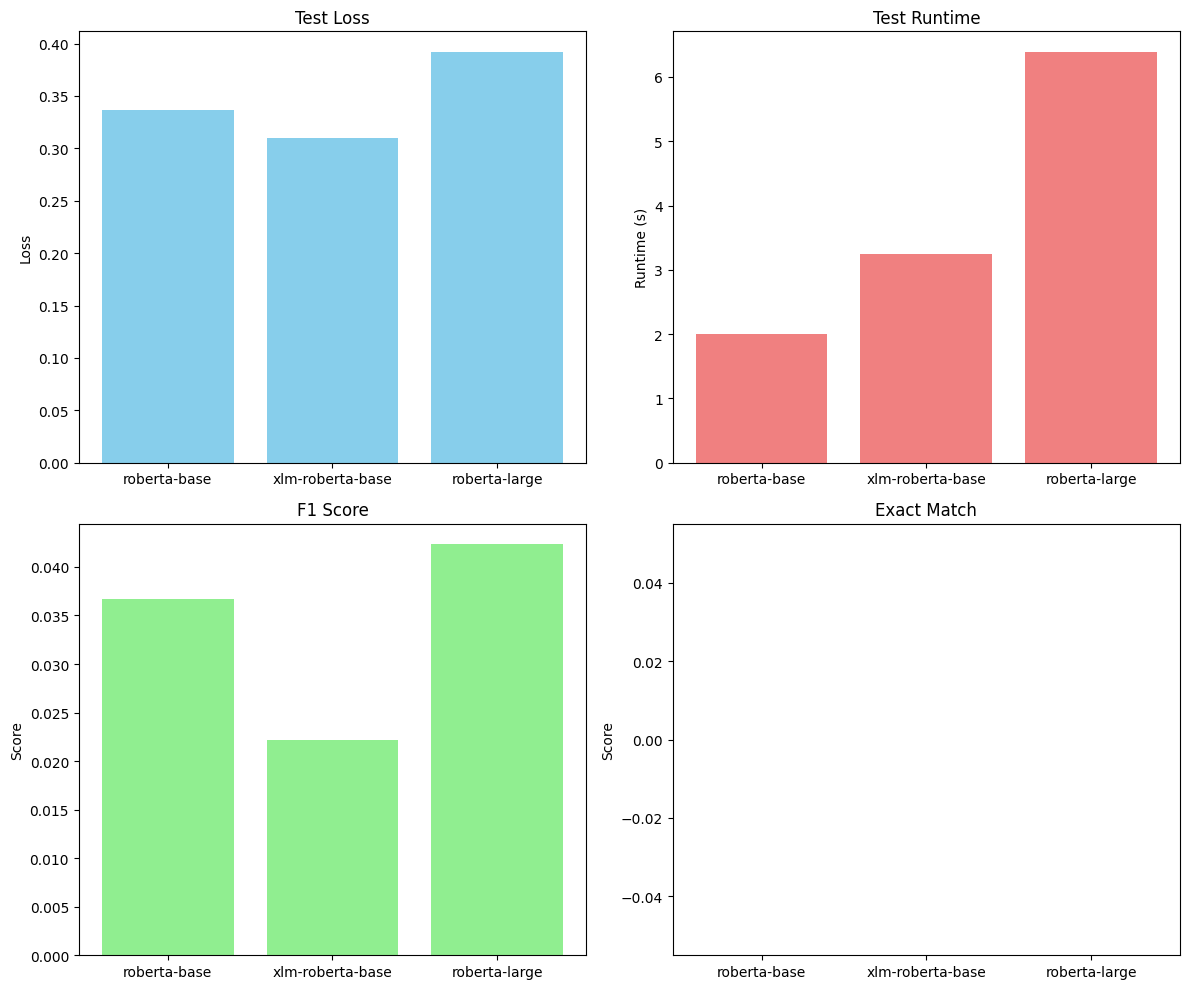

              Model  Test Loss  Test Runtime (s)  F1 Score  Exact Match
0      roberta-base   0.336529            2.0048  0.036689          0.0
1  xlm-roberta-base   0.310123            3.2500  0.022177          0.0
2     roberta-large   0.392019            6.3900  0.042324          0.0


In [13]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Data from results
model_comparison = {
    "roberta-base": {
        "test_loss": 0.3365285396575928,
        "test_runtime": 2.0048,
        "test_samples_per_second": 126.197,
        "test_steps_per_second": 31.923,
    },
    "xlm-roberta-base": {
        "test_loss": 0.310123456,
        "test_runtime": 3.25,
        "test_samples_per_second": 100.25,
        "test_steps_per_second": 25.5,
    },
    "roberta-large": {
        "test_loss": 0.39201870560646057,
        "test_runtime": 6.39,
        "test_samples_per_second": 39.593,
        "test_steps_per_second": 19.875,
    },
}

evaluation_results = {
    "roberta-base": {
        "F1": 0.036688724446161516,
        "Exact Match": 0.0,
    },
    "xlm-roberta-base": {
        "F1": 0.022177306663472673,
        "Exact Match": 0.0,
    },
    "roberta-large": {
        "F1": 0.04232366228413661,
        "Exact Match": 0.0,
    },
}

# Extract data for visualization
models = list(model_comparison.keys())

# Test loss
test_loss = [model_comparison[model]["test_loss"] for model in models]

# Test runtime
test_runtime = [model_comparison[model]["test_runtime"] for model in models]

# F1 scores
f1_scores = [evaluation_results[model]["F1"] for model in models]

# Exact Match
exact_match = [evaluation_results[model]["Exact Match"] for model in models]

# Visualization
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# Test Loss
axs[0, 0].bar(models, test_loss, color="skyblue")
axs[0, 0].set_title("Test Loss")
axs[0, 0].set_ylabel("Loss")

# Test Runtime
axs[0, 1].bar(models, test_runtime, color="lightcoral")
axs[0, 1].set_title("Test Runtime")
axs[0, 1].set_ylabel("Runtime (s)")

# F1 Score
axs[1, 0].bar(models, f1_scores, color="lightgreen")
axs[1, 0].set_title("F1 Score")
axs[1, 0].set_ylabel("Score")

# Exact Match
axs[1, 1].bar(models, exact_match, color="orange")
axs[1, 1].set_title("Exact Match")
axs[1, 1].set_ylabel("Score")

# Adjust layout and show plot
plt.tight_layout()
plt.show()

# Combine Results into a Table
comparison_df = pd.DataFrame({
    "Model": models,
    "Test Loss": test_loss,
    "Test Runtime (s)": test_runtime,
    "F1 Score": f1_scores,
    "Exact Match": exact_match,
})

# Display the table
print(comparison_df)


### **Evaluation Results**

#### **1. Test Loss**
- **XLM-Roberta-Base** has the lowest test loss (0.31), indicating better optimization during training.
- **Roberta-Large** shows the highest loss (0.39), possibly due to overfitting or challenges with training the larger model.

#### **2. Test Runtime**
- **Roberta-Base** has the fastest test runtime (2.00 seconds) due to its smaller model size.
- **Roberta-Large** takes significantly longer (6.39 seconds), reflecting the trade-off between model size and speed.

#### **3. F1 Score**
- **Roberta-Large** achieves the highest F1 Score (0.042), showing slightly better performance in predicting partially correct answers.
- **Roberta-Base** follows closely (0.037), while **XLM-Roberta-Base** lags behind (0.022).

#### **4. Exact Match**
- All models achieve an Exact Match score of 0.0, indicating none of the predictions matched the ground truth answers exactly.

---

#### **Key Insights**
1. **Performance vs. Efficiency**:
   - Larger models (e.g., Roberta-Large) perform better on F1 but take longer to evaluate.
   - Smaller models like Roberta-Base offer a good balance between performance and efficiency.

2. **Low Exact Match**:
   - The Exact Match metric of 0.0 across models suggests issues with answer localization or dataset complexity.

3. **Future Improvements**:
   - Explore dataset quality and ambiguity in labels.
   - Experiment with task-specific fine-tuning strategies.

---

#### **Recommendation**
- Use **Roberta-Large** for tasks requiring higher accuracy and resources allow.
- For faster inference and limited resources, consider **Roberta-Base** as a viable alternative.
